In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../src/')
import models
import generation_utils
import metrics_utils
import tokenizer
import data_utils
from utils import get_best_checkpoint

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
pd.set_option('display.max_colwidth', 999)
pd.set_option('display.max_rows', 9999)

In [4]:
device = torch.device('cuda')

In [5]:
base_path = '../models/base_24_2^18/'

In [6]:
checkpoint = get_best_checkpoint(base_path)

Loading model at ../models/base_24_2^18/checkpoints/730000_0.1004.pt


In [7]:
args = checkpoint['args']

In [9]:
t = tokenizer.Tokenizer(base = args['data']['base'])

In [10]:
args.keys()

dict_keys(['data', 'model_args', 'optimizer', 'scheduler', 'loader', 'io', 'metrics', 'multi_gpu', 'verbose', 'tokenizer'])

In [11]:
model = models.Factorizer(n_tokens = args['tokenizer']['n_tokens'], 
                          pad_token_id = args['tokenizer']['pad_token_id'],
                          **args['model_args'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

Factorizer(
  (embedding): TransformerEmbedding(
    (embedding): Embedding(28, 128)
    (pe): PositionalEncoding(
      (dropout): Dropout(p=0.05, inplace=False)
    )
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.05, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.05, inplace=False)
          (dropout2): Dropout(p=0.05, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            

# Visualize Embeddings

In [12]:
embeddings = model.embedding.embedding.weight.data.cpu().numpy()

In [13]:
tokens = [''.join(t.decode([i], decode_special=True)) for i in range(len(t))]
special_tokens = set(['x', '_', '>', '.'])
tokens = np.array([tok if tok in special_tokens else data_utils.base2dec([int(tok)], args['data']['base']) for tok in tokens])

In [14]:
embeddings.shape

(28, 128)

In [15]:
tokens.shape

(28,)

In [16]:
tokens

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       'x', '_', '.', '>'], dtype='<U11')

## TSNE
* Doesn't seem to be super interesting

In [17]:
from sklearn.manifold import TSNE

In [18]:
tsne = TSNE(perplexity=30, learning_rate=200, n_iter=1000)
embeddings_for_plot = tsne.fit_transform(embeddings)

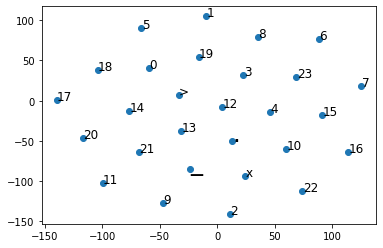

In [19]:
plt.scatter(embeddings_for_plot[:,0], embeddings_for_plot[:,1])
ax = plt.gca()
for tok, (x,y) in zip(tokens, embeddings_for_plot):
    fontsize = 12 if not tok in ['.', '_'] else 24
    ax.annotate(tok, (x+.3,y), fontsize=fontsize)
plt.show()

## Cosine Similarity
* Some embeddings have relatively simlar cosine similarities

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

In [45]:
cs_sim_mat = cosine_similarity(embeddings)
cs_sims = np.triu(cs_sim_mat, 1).ravel()
cs_sims = cs_sims[~np.isclose(cs_sims, 0)]

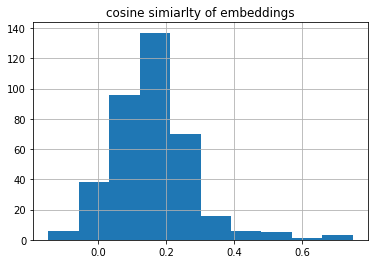

In [46]:
plt.title('cosine simiarlty of embeddings')
pd.Series(cs_sims).hist()
plt.show()

In [47]:
cs_sim_mat.shape

(28, 28)

In [51]:
cs_sim_mat

array([[ 1.0000001 ,  0.20947157,  0.12409612,  0.09352618,  0.14274287,
         0.1483083 ,  0.25185296,  0.1967082 ,  0.09906537,  0.07954345,
         0.24456161,  0.07309192,  0.24926093,  0.12558152,  0.09385978,
        -0.01023844,  0.19143035,  0.09078324,  0.14960185,  0.15796833,
         0.06624856,  0.21853077,  0.22200237,  0.0095817 ,  0.28712404,
         0.01520046,  0.20431857,  0.23378865],
       [ 0.20947157,  1.        ,  0.40349138,  0.2897607 ,  0.30031124,
         0.3908712 ,  0.28289518,  0.41249555,  0.23237519,  0.17732228,
         0.22023821,  0.25866315,  0.14750424,  0.3370837 ,  0.14793764,
         0.2015448 ,  0.24701005,  0.30432042,  0.16685933,  0.17232986,
         0.08069484,  0.3746502 ,  0.21636525,  0.21139815,  0.6191268 ,
        -0.04172302,  0.48982775,  0.53016627],
       [ 0.12409612,  0.40349138,  1.        ,  0.27189764,  0.10707545,
         0.26574343,  0.14032036,  0.22256562,  0.09540227,  0.1540948 ,
         0.15306129,  0.2048

In [70]:
mat_show_mat[mat_show_mat<.99].max()

0.41249555

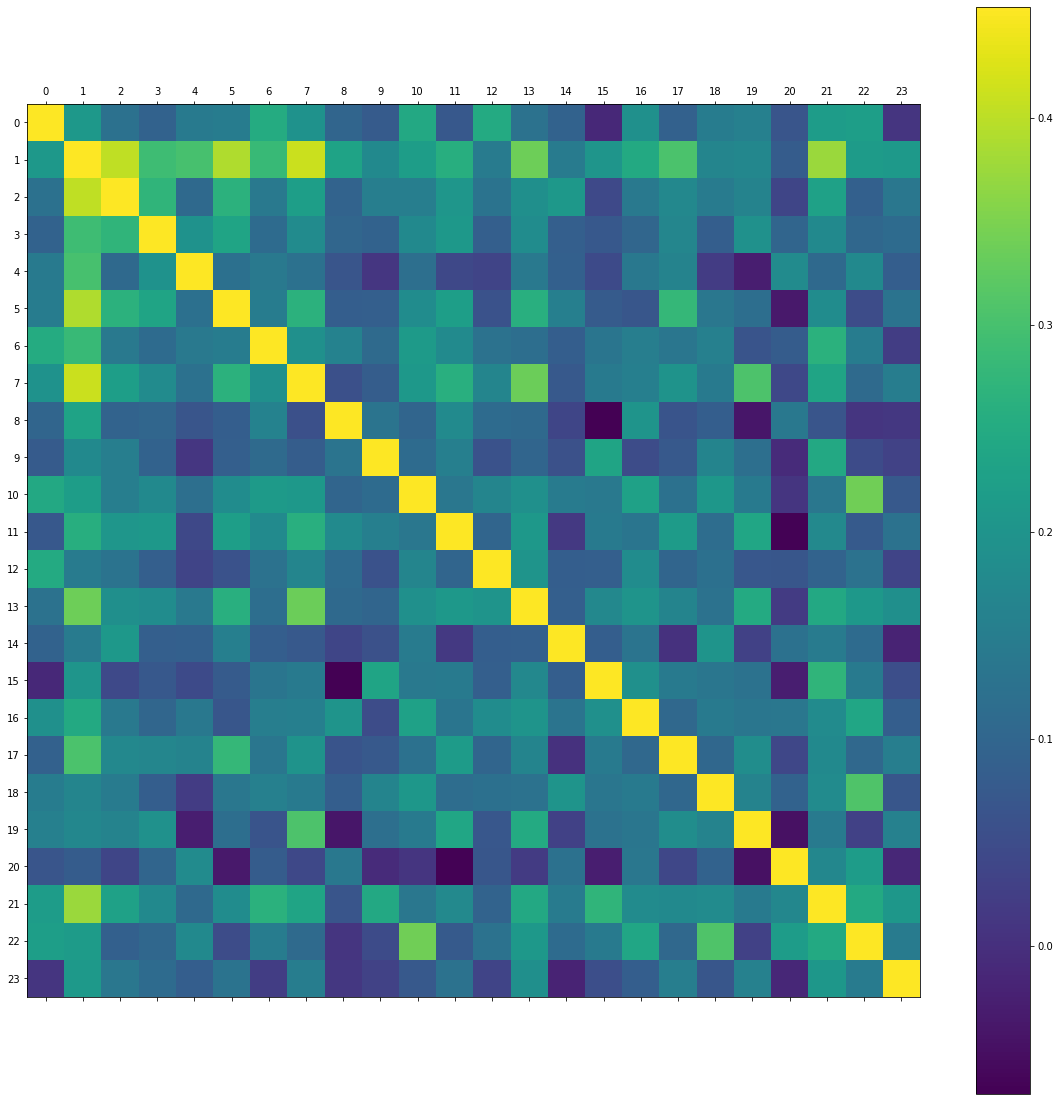

In [71]:
mat_show_mat = cs_sim_mat[:-4,:-4]

fig = plt.gcf()
fig.set_size_inches(20, 20)
ax = plt.gca()
plt.colorbar(ax.matshow(np.clip(mat_show_mat, a_min=-1, a_max=mat_show_mat[mat_show_mat<.99].max()*1.1)), ax=ax)
ax.set_xticks(np.arange(mat_show_mat.shape[0]))
ax.set_yticks(np.arange(mat_show_mat.shape[0]))
ax.set_xticklabels(tokens[:mat_show_mat.shape[0]])
ax.set_yticklabels(tokens[:mat_show_mat.shape[0]])
plt.show()

In [62]:
cs_sim_mat[cs_sim_mat<1].max()*1.1

1.0999999344348907

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [24]:
logreg = LogisticRegression(C = .1, penalty='l1', solver='liblinear')
# logreg = SVC()

In [25]:
embeddings.shape, tokens.shape

((28, 128), (28,))

In [26]:
logreg_x = embeddings[:-4]
logreg_y = tokens[:-4].astype(int) % 2

In [27]:
train_indexer = np.random.rand(logreg_x.shape[0]) < .8
logreg_x_train = logreg_x[train_indexer]
logreg_x_test = logreg_x[~train_indexer]

logreg_y_train = logreg_y[train_indexer]
logreg_y_test = logreg_y[~train_indexer]

In [28]:
logreg_x_train.shape, logreg_y_train.shape

((17, 128), (17,))

In [29]:
logreg_x_test.shape, logreg_y_test.shape

((7, 128), (7,))

In [30]:
logreg.fit(logreg_x_train, logreg_y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [31]:
logreg.score(logreg_x_test, logreg_y_test)

0.7142857142857143

# How well does the model do on numbers higher than what it was trained on?

In [32]:
start = 2**18
length = 4096
numbers = np.arange(start, start + length)

In [33]:
import importlib
importlib.reload(metrics_utils)
importlib.reload(generation_utils)

<module 'generation_utils' from '../src\\generation_utils.py'>

In [34]:
t

In [36]:
larger_df = metrics_utils.form_factor_df(model, t, device, args['data']['base'], numbers, args['model_args']['max_decode_size'], postprocess_minimal=True, n_beams = 10)

In [37]:
larger_df.shape

(40960, 7)

In [38]:
larger_df.head(5)

,target_num,beam_idx,log_prob,pred_factor_list,product,correct_product,correct_factorization
0,65536,0,-2.182287,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 23]",94208,False,False
1,65536,1,-2.500107,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5]",81920,False,False
2,65536,2,-2.718703,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",65536,True,True
3,65536,3,-2.779272,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5]",163840,False,False
4,65536,4,-2.797647,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 17]",69632,False,False


In [39]:
larger_df.groupby('target_num').agg({'correct_factorization' : 'any'}).mean()

correct_factorization    0.898926
dtype: float64

In [40]:
top_beams = larger_df['beam_idx'] == 9
(larger_df[top_beams]['product'] < larger_df[top_beams]['target_num']).mean()

0.370849609375

In [72]:
generation_utils.factor

<function generation_utils.factor(number, base, model, tokenizer, device, max_decode_size, n_beams=1, temperature=1.0, return_type='df', postprocess_minimal=False)>

In [111]:
from sympy import factorint
from sympy.ntheory import primerange

In [116]:
np.array(list(primerange(2, 10)))**2

array([ 4,  9, 25, 49], dtype=int32)

In [103]:
test_num = 1223*1223

In [104]:
factorint(test_num)

{1223: 2}

### how does it handle squares/cubes/...?

In [123]:
max_num = 100
squares = np.array(list(primerange(2, max_num)))**2
cubes = np.array(list(primerange(2, max_num)))**3

In [124]:
square_df = metrics_utils.form_factor_df(model, t, device, args['data']['base'], squares, args['model_args']['max_decode_size'], postprocess_minimal=True, n_beams = 10)

In [125]:
square_df[square_df['beam_idx']==0]['correct_factorization'].mean()

1.0

In [126]:
cube_df = metrics_utils.form_factor_df(model, t, device, args['data']['base'], cubes, args['model_args']['max_decode_size'], postprocess_minimal=True, n_beams = 10)

In [127]:
cube_df[cube_df['beam_idx']==0]['correct_factorization'].mean()

0.4

In [105]:
generation_utils.factor(test_num, args['data']['base'], model, t, device, args['model_args']['max_decode_size'], n_beams=25)

,target_num,beam_idx,log_prob,pred_factor_list,product,correct_product,correct_factorization,target_is_prime,input_string,pred_list,pred_str,target_str,target_factor_list,n_target_factors,n_pred_factors,num_prime_factors_pred,percent_prime_factors_pred,pred_same_as_target,min_target_prime_factor_if_composite
0,1495729,0,-2.320875,[62323],62323,False,False,False,"[4, 12, 4, 18, 1]","[[4, 12, 4, 19]]",> 4 12 4 19 . _ _ _ _ _ _ _ _,> 2 2 23 x 2 2 23 .,"[1223, 1223]",2,1,1,1.000000,False,1223
1,1495729,1,-4.600385,"[23, 2741]",63043,False,False,False,"[4, 12, 4, 18, 1]","[[23], [4, 18, 5]]",> 23 x 4 18 5 . _ _ _ _ _ _ _,> 2 2 23 x 2 2 23 .,"[1223, 1223]",2,2,2,1.000000,False,1223
2,1495729,2,-5.397596,"[5, 47, 257]",60395,False,False,False,"[4, 12, 4, 18, 1]","[[5], [1, 23], [10, 17]]",> 5 x 1 23 x 10 17 . _ _ _ _ _,> 2 2 23 x 2 2 23 .,"[1223, 1223]",2,3,3,1.000000,False,1223
3,1495729,3,-5.501613,"[5, 67, 229]",76715,False,False,False,"[4, 12, 4, 18, 1]","[[5], [2, 19], [9, 13]]",> 5 x 2 19 x 9 13 . _ _ _ _ _,> 2 2 23 x 2 2 23 .,"[1223, 1223]",2,3,3,1.000000,False,1223
4,1495729,4,-5.868195,"[5, 53, 227]",60155,False,False,False,"[4, 12, 4, 18, 1]","[[5], [2, 5], [9, 11]]",> 5 x 2 5 x 9 11 . _ _ _ _ _,> 2 2 23 x 2 2 23 .,"[1223, 1223]",2,3,3,1.000000,False,1223
5,1495729,5,-5.881566,"[73, 2347]",171331,False,False,False,"[4, 12, 4, 18, 1]","[[3, 1], [4, 1, 19]]",> 3 1 x 4 1 19 . _ _ _ _ _ _,> 2 2 23 x 2 2 23 .,"[1223, 1223]",2,2,2,1.000000,False,1223
6,1495729,6,-5.966593,"[5, 53, 235]",62275,False,False,False,"[4, 12, 4, 18, 1]","[[5], [2, 5], [9, 19]]",> 5 x 2 5 x 9 19 . _ _ _ _ _,> 2 2 23 x 2 2 23 .,"[1223, 1223]",2,3,2,0.666667,False,1223
7,1495729,7,-6.081643,"[5, 7, 1921]",67235,False,False,False,"[4, 12, 4, 18, 1]","[[5], [7], [3, 8, 1]]",> 5 x 7 x 3 8 1 . _ _ _ _ _,> 2 2 23 x 2 2 23 .,"[1223, 1223]",2,3,2,0.666667,False,1223
8,1495729,8,-6.114621,"[37, 53, 83]",162763,False,False,False,"[4, 12, 4, 18, 1]","[[1, 13], [2, 5], [3, 11]]",> 1 13 x 2 5 x 3 11 . _ _ _ _,> 2 2 23 x 2 2 23 .,"[1223, 1223]",2,3,3,1.000000,False,1223
9,1495729,9,-6.123154,"[5, 43, 349]",75035,False,False,False,"[4, 12, 4, 18, 1]","[[5], [1, 19], [14, 13]]",> 5 x 1 19 x 14 13 . _ _ _ _ _,> 2 2 23 x 2 2 23 .,"[1223, 1223]",2,3,3,1.000000,False,1223
